In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx

np.random.seed(0) # Fix seed for reproducibility
random.seed(0) # Fix seed for reproducibility

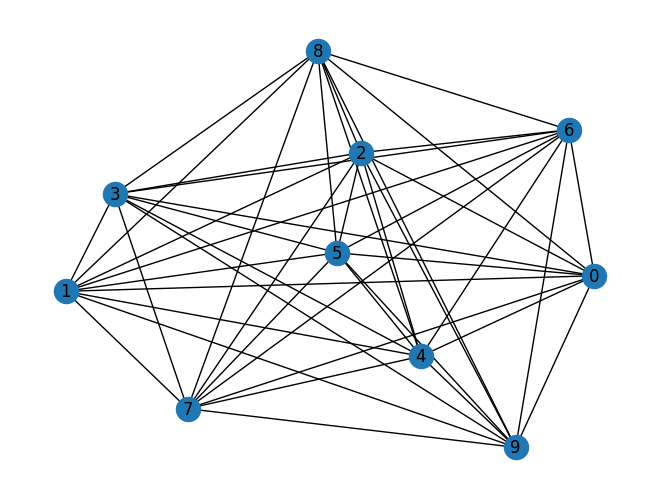

[[ 0.  7.  7.  1.  5.  9.  8.  7.  5.  8.]
 [ 7.  0.  6. 10.  4.  9.  3.  5.  3.  2.]
 [ 7.  6.  0. 10.  5.  9. 10.  3.  5.  2.]
 [ 1. 10. 10.  0.  2.  6.  8.  9.  2.  6.]
 [ 5.  4.  5.  2.  0.  7.  6. 10.  4.  9.]
 [ 9.  9.  9.  6.  7.  0.  8.  8.  9.  5.]
 [ 8.  3. 10.  8.  6.  8.  0.  1.  9.  1.]
 [ 7.  5.  3.  9. 10.  8.  1.  0.  2.  7.]
 [ 5.  3.  5.  2.  4.  9.  9.  2.  0.  1.]
 [ 8.  2.  2.  6.  9.  5.  1.  7.  1.  0.]]


In [2]:
def generate_random_graph(n=10, weight_range=(1, 10)):
    # First thing is to create the map that we're trying to visit
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            weight = random.randint(*weight_range)
            matrix[i][j] = weight
            matrix[j][i] = weight
    return matrix

adjency_matrix = generate_random_graph(n=10, weight_range=(1, 10))
G = nx.from_numpy_array(adjency_matrix)
nx.draw(G, with_labels=True)
plt.show()
print(adjency_matrix)

# 1. Initialisation

Créez une population initiale. Cette population est généralement générée aléatoirement. Chaque individu, ou chromosome, dans cette population représente une solution possible au problème (dans ce cas, une séquence possible de livraisons pour les véhicules).

In [3]:
def create_individual(nb_client, starting_point=0):
    """
    Create a random individual
    """
    clients = list(range(1, nb_client))
    random.shuffle(clients)

    return [starting_point] + clients + [starting_point]


def create_population(nb_client, starting_point=0, size=100):
    """
    Create a population of individuals
    """
    return [create_individual(nb_client, starting_point) for _ in range(size)]

# 2. Evaluation
Calculez la fonction de fitness pour chaque individu dans la population. La fonction de fitness détermine la qualité d'une solution. Dans le cas du VRP, cela pourrait être la distance totale parcourue par tous les véhicules.

In [4]:
def fitness(individual, adjency_matrix):
    """
    Compute the fitness of an individual
    """
    fitness = 0
    for i in range(len(individual)-1):
        fitness += adjency_matrix[individual[i]][individual[i+1]]
    return fitness

# 3. Selection
Sélectionnez des individus pour la reproduction. Il existe plusieurs stratégies de sélection, comme la sélection par roulette (plus la fitness d'un individu est élevée, plus il a de chances d'être sélectionné) ou la sélection par tournoi (choisissez aléatoirement quelques individus et sélectionnez le meilleur parmi eux).

In [5]:
def selection(population, adjency_matrix, k=10):
    """
    Select the best individuals in the population
    """
    # We need to sort the population by fitness
    # https://docs.python.org/3/howto/sorting.html
    # Select the k best individuals with the lowest fitness
    population = sorted(population, key=lambda x: fitness(x, adjency_matrix))
    return population[:k]

# 4. Crossover
Créez une nouvelle génération de chromosomes en croisant les individus sélectionnés. Par exemple, en prenant la première moitié du chemin d'un parent et en complétant avec les villes restantes dans l'ordre qu'elles apparaissent dans le second parent.

In [6]:
def crossover(parent1, parent2):
    # Supprimer la première et la dernière valeur de chaque parent
    p1 = parent1[1:-1]
    p2 = parent2[1:-1]
    
    # Générer un point de croisement aléatoire
    cross_point = random.randint(1, len(p1) - 1)
    
    # Créer un nouvel enfant en combinant les segments des deux parents
    child = p1[:cross_point] + p2[cross_point:]
    
    # Vérifier et supprimer les doublons dans la partie héritée du parent2
    for gene in child[:cross_point]:
        if gene in child[cross_point:]:
            child.remove(gene)
    
    # Si le croisement supprime certains gènes, compléter le nouvel enfant avec les gènes manquants
    for gene in p1:
        if gene not in child:
            child.append(gene)
    
    # Ajouter la première et la dernière valeur
    child.insert(0, parent1[0])
    child.append(parent1[-1])
    
    return child

# 4. Mutation
Apportez de petites modifications aléatoires à certains individus dans la nouvelle génération. Par exemple, en échangeant deux villes dans l'itinéraire.

In [7]:
def mutation(individual, adjency_matrix):
    """
    Mutate an individual
    """
    # We select two random points in the individual
    # and we swap them
    i, j = random.sample(range(1, len(individual)-1), 2)
    individual[i], individual[j] = individual[j], individual[i]
    return individual

# 5. Remplacement
Remplacez l'ancienne population par la nouvelle génération d'individus.

In [8]:
def renew_population(population, adjency_matrix, k=10, mutation_rate=0.15):
    """
    Renew the population
    """
    population_size = len(population)

    # Select the best individuals
    population = selection(population, adjency_matrix, k=k)
    
    while len(population) < population_size:
        # Use threads to speed up the crossover and mutation operations
        parent1 = random.choice(population)
        parent2 = random.choice(population)
        child = crossover(parent1, parent2)
        if random.random() < mutation_rate:
            child = mutation(child, adjency_matrix)
        population.append(child)
        

    return population

# 6. Convergence
Vérifiez si l'algorithme a atteint un critère d'arrêt. Cela peut être un nombre maximum de générations, un temps d'exécution maximal, ou un seuil de fitness. Si le critère n'est pas atteint, revenez à l'étape 2.

In [9]:
def convergence(population, adjency_matrix):
    """
    Check if the population has converged
    """
    # We need to check if all the individuals have the same fitness
    fitnesses = [fitness(individual, adjency_matrix) for individual in population]
    return len(set(fitnesses)) == 1

# 7. Run

[0, 1393, 1801, 1218, 1203, 1876, 305, 1314, 1520, 1932, 1768, 1742, 1245, 413, 1790, 1556, 1276, 633, 1804, 1933, 1831, 1224, 423, 1339, 320, 17, 1299, 447, 534, 1721, 982, 988, 116, 872, 1717, 1743, 60, 278, 306, 659, 682, 822, 290, 627, 1636, 1329, 1112, 390, 768, 991, 1543, 1652, 405, 671, 1863, 537, 1724, 590, 1977, 1202, 1603, 841, 1646, 395, 1647, 1894, 1020, 1746, 1830, 162, 1622, 1633, 615, 1702, 884, 634, 1413, 12, 866, 1926, 833, 1070, 1931, 1231, 233, 261, 149, 342, 983, 16, 1219, 375, 178, 1586, 1512, 704, 1030, 1053, 1066, 1777, 1949, 1537, 1259, 1858, 1822, 565, 1213, 880, 1731, 1918, 150, 300, 1979, 1712, 651, 626, 358, 1840, 478, 1295, 593, 773, 1501, 415, 73, 1287, 907, 1983, 882, 446, 577, 160, 277, 1349, 1368, 1772, 329, 811, 195, 554, 440, 69, 1827, 494, 1903, 91, 379, 902, 1775, 1195, 1318, 248, 1247, 1588, 753, 744, 1635, 1856, 1135, 147, 1565, 1311, 485, 612, 977, 97, 18, 1630, 1959, 424, 774, 1360, 1884, 476, 1534, 1307, 167, 385, 1106, 1703, 207, 1123, 955, 13

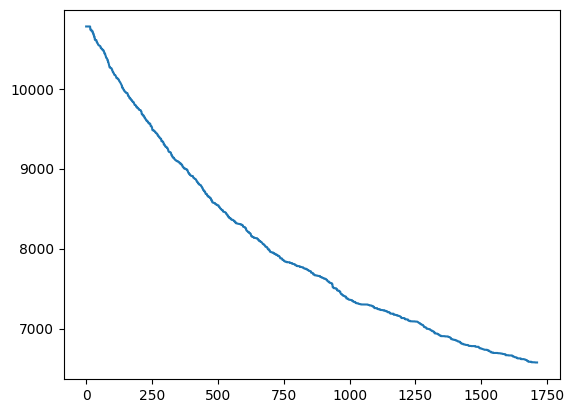

In [10]:
def genetic_algorithm(adjency_matrix, starting_point=0, population_size=100, k=10, mutation_rate=0.15):
    """
    Run the genetic algorithm
    """
    # Create the initial population
    population = create_population(nb_client=len(adjency_matrix), starting_point=starting_point, size=population_size)
    # Loop until convergence
    fitnesses_evolution = []
    while not convergence(population, adjency_matrix):
        print("Best fitness:", fitness(population[0], adjency_matrix), end="\r")
        population = renew_population(population, adjency_matrix, k=k, mutation_rate=mutation_rate)
        fitnesses_evolution.append((len(fitnesses_evolution), fitness(population[0], adjency_matrix)))

    # Select the best individual
    best_individual = selection(population, adjency_matrix, k=1)[0]
    return best_individual, fitnesses_evolution

adjency_matrix = generate_random_graph(2000)
best_individual, fitnesses_evolution = genetic_algorithm(adjency_matrix, starting_point=0, population_size=30, k=15, mutation_rate=0.15)
print(best_individual)
print(fitness(best_individual, adjency_matrix))

plt.plot(*zip(*fitnesses_evolution))

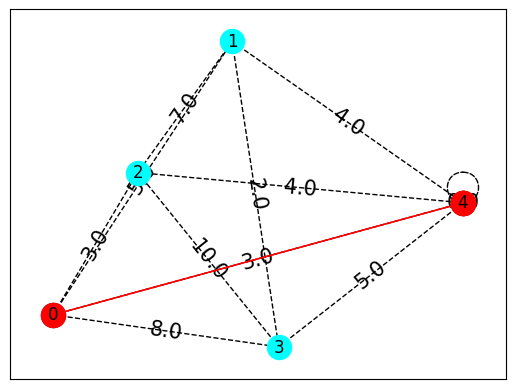

In [114]:
from mpl_interactions import ioff, panhandler, zoom_factory
import matplotlib.pyplot as plt
import networkx as nx


def plot_graph(adjency_matrix, trajet):
    # Création du graphe
    G = nx.from_numpy_array(adjency_matrix)

    # Ajout des arêtes pour chaque trajet
    for i in range(len(trajet) - 1):
        G.add_edge(trajet[i], trajet[i+1], weight=adjency_matrix[trajet[i]][trajet[i+1]])

    # Dessin du graphe
    pos = nx.spring_layout(G)

    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)
    

    # Dessin des noeuds et des arêtes en noir
    nx.draw_networkx(G, pos, with_labels=True, node_color='cyan', edge_color='black', style='dashed')

    # Dessin des trajets par dessus en couleurs
    trajet_edges = [(trajet[i], trajet[i+1]) for i in range(len(trajet) - 1)]
    nx.draw_networkx_nodes(G, pos, nodelist=trajet, node_color="red")
    nx.draw_networkx_edges(G, pos, edgelist=trajet_edges, edge_color="red")

    plt.show()


plot_graph(adjency_matrix, best_individual)

In [113]:
# Check if an individual is valid
def is_valid(individual, adjency_matrix, starting_point=0):
    dict_client = {i:0 for i in range(len(adjency_matrix))}
    is_valid = True

    for truck, trajet in individual.items():
        # Check if the cycle starts and ends at the starting point
        if trajet[0] != starting_point or trajet[-1] != starting_point:
            is_valid = False
            break

        for vertice in trajet[1:-1]:
            dict_client[vertice] += 1

    # Check if all the clients are visited exactly once
    for client, nb_visits in dict_client.items():
        if nb_visits != 1:
            is_valid = False
            break

    return is_valid

is_valid(best_individual, adjency_matrix)
best_individual

AttributeError: 'list' object has no attribute 'items'